In [1]:
(* Derive basis functions and their gradients *)
stdBasis = {1, u, v, u^2, u * v, v^2};
pts = {{0,0}, {1,0}, {0,1}, {1/2,0}, {1/2, 1/2}, {0, 1/2}};
genH[pts_, basis_] := Table[basis /. {u -> pts[[i,1]], v -> pts[[i,2]]},{i,1,Length[pts]}];
h = genH[pts, stdBasis];
invH = Inverse[h];
psis = Transpose[invH] . stdBasis;
(*psis // MatrixForm*)
(*Check that it worked*)
(*Table[psis /. {u -> pts[[i,1]], v -> pts[[i,2]]}, {i,1,Length[psis]}] // MatrixForm*)
gpsi = Grad[psis, {u,v}];
(*gpsi // MatrixForm*)

(* The standard linear basis *)
psi3 = {1 - u - v, u, v};

In [15]:
(* Utilities *)
stdTri = Triangle[{{0,0},{0,1},{1,0}}];

(* Returns {x(u,v), y(u,v)} *)
getTransform[globalPts_] := Module[{xChange,yChange},
(
    xChange = Simplify[psis . Transpose[globalPts[[;;, 1]]]];
    yChange = Simplify[psis . Transpose[globalPts[[;;, 2]]]];
    Return[{xChange, yChange}];
)];

(* Returns {x(u,v), y(u,v)} but with the linear basis *)
getLinearTransform[globalPts_] := Module[{xChange,yChange},
(
    xChange = Simplify[psi3 . Transpose[globalPts[[1;;3, 1]]]];
    yChange = Simplify[psi3 . Transpose[globalPts[[1;;3, 2]]]];
    Return[{xChange, yChange}];
)];

(* Find the max deviation of a linear transform compared to the regular one *)
transformAccuracy[globalPts_] := Module[{t1,t2},
(
    t1 = getTransform[globalPts];
    t2 = getLinearTransform[globalPts];
    Return[Maximize[Norm[t1 - t2], Element[{u,v}, stdTri]][[1]]];
)];

(* Returns {x(u, v), y(u, v)}, where the change is linear except when the error wrt the quadratic is big enough *)
(* This is needed so that NIntegrate runs fast and doesn't complain for internal elements *)
(* The problem is that due to numerical imprecision the quadratic change doesn't always simplify to a linear one
and this causes instability in the Jacobian *)
getTransformAuto[globalPts_] := Module[{t1,t2,d},
(
    t1 = getTransform[globalPts];
    t2 = getLinearTransform[globalPts];
    d = Maximize[Norm[t1 - t2], Element[{u,v}, stdTri]][[1]];
    Return[If[d >= 10^(-6), t1, t2]];
)];

(* Local load vector (with f == 1) *)
llv[globalPts_] := Module[{trans, J, dJ},
(
    trans = getTransformAuto[globalPts];
    J = Transpose[{D[trans, u], D[trans, v]}];
    dJ = Simplify[Det[J]];
    Return[NIntegrate[psis * dJ, Element[{u,v}, stdTri]]];
)];
(* Local stiffness matrix (symbolic and very slow) *)
lsm[globalPts_] := Module[{trans, J, dJ},
(
    trans = getTransformAuto[globalPts];
    J = Transpose[{D[trans, u], D[trans, v]}];
    dJ = Simplify[Det[J]];
    JTJ = Transpose[Inverse[J]] . Inverse[J];
    Return[Integrate[gpsi . JTJ . Transpose[gpsi] * dJ, Element[{u,v}, stdTri]]];
)];
(* Local stiffness matrix (numeric) *)
lsmN[globalPts_] := Module[{trans, J, dJ},
(
    trans = getTransformAuto[globalPts];
    J = Transpose[{D[trans, u], D[trans, v]}];
    dJ = Simplify[Det[J]];
    JTJ = Transpose[Inverse[J]] . Inverse[J];
    Return[NIntegrate[gpsi . JTJ . Transpose[gpsi] * dJ, Element[{u,v}, stdTri]]];
)];

ElementMesh[{{-1., 1.}, {-1., 1.}}, {TriangleElement[<62>]}]
-Graphics-
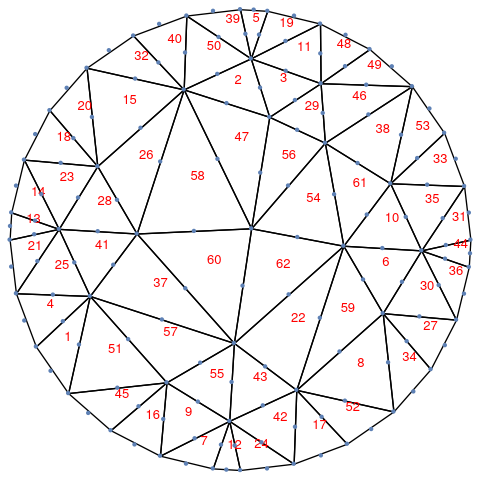

In [33]:
(* Generate the mesh - large triangle for better runtime *)
Needs["NDSolve`FEM`"]
omega = Disk[{0,0}, 1];
mesh = ToElementMesh[omega, "MeshOrder" -> 2, MaxCellMeasure->30, MaxBoundaryCellMeasure->30]
elements = mesh["MeshElements"][[1, 1]];
nodes = mesh["Coordinates"];
boundary =Flatten[mesh["BoundaryElements"][[1,1]]];
boundary=DeleteDuplicates[boundary];
Show[mesh["Wireframe"["MeshElementIDStyle"->Red]], ListPlot[nodes]]

(*Resolved triangle points*)
nPts = Length[nodes];
nTri = Length[elements];
verts = Table[nodes[[elements[[i]]]], {i,1,nTri}];

In [46]:
(* Compute local matrices and vectors - sloooow *)
localMats = Table[lsmN[verts[[i]]], {i,1,nTri}];
localVecs = Table[llv[verts[[i]]], {i,1,nTri}];

In [49]:
(* Assemble the global matrix and vector *)
m0 = ConstantArray[0, {nPts, nPts}];
b0 = ConstantArray[0, nPts];
For[i = 1, i <= nTri, i++,
(
    ids = elements[[i]];
    m0[[ids, ids]] += localMats[[i]];
    b0[[ids]] += localVecs[[i]] * (-1); (* Fix the sign here *)
)];

In [53]:
(* Remove boundary nodes *)
intIds = Complement[Table[i, {i,1,nPts}], boundary];
m = m0[[intIds, intIds]];
b = b0[[intIds]];
(* Solve for internal nodes *)
qI = LinearSolve[m,b];
(* Compose full solution *)
q = ConstantArray[0, nPts];
q[[intIds]] = qI;

Interpolation::udeg: Interpolation on unstructured grids is currently only supported for InterpolationOrder->1 or InterpolationOrder->All. Order will be reduced to 1.

InterpolatingFunction[{{-1., 1.}, {-1., 1.}}, <>]
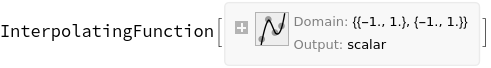

In [62]:
f = Interpolation[Transpose[{mesh["Coordinates"], Flatten[q]}], InterpolationOrder -> 2]

-Graphics3D-
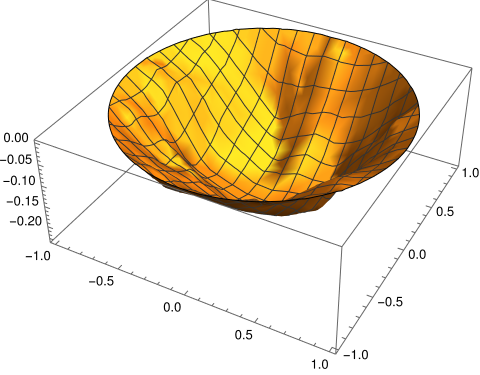

In [63]:
Plot3D[f[x,y], Element[{x,y}, omega]]